<a id="top5"></a>
# Random forest model

In this notebook I will implement a Random Forest model with hyperparametes tuning and analysis:

- [Data preparation](#part5a)
- [Random Forest model with tuning](#part5b)
- [Most important features](#part5c)
- [Confusion matrix](#part5d)

### <a id='part5a'>Data preparation</a>

Let's import the dataset previously exported and extract the `X` feature matrix and the `y` target:

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")

# Import the dataset with the features
df = pd.read_csv('emotions_data_transformed.csv')

# Convert target to numerical values
df['emotion'].replace({'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}, inplace=True)
df['gender'].replace({'female':0,'male':1}, inplace=True)

# Create feature matrix (X) and numerical target (y)
X = df.drop(columns=['path','filename','dataset','duration','age','emotion'])
y = df.emotion.values

The data will be splitted into training and test set. The validation set will be implemented afterwards.

In [2]:
from sklearn.model_selection import train_test_split

# Create train and test set
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.9, shuffle=True, stratify=y, random_state=0)

# Checking size
print('Shape of X_tr: ', X_tr.shape)
print('Shape of y_tr: ', y_tr.shape)
print('Shape of X_te: ', X_te.shape)
print('Shape of y_te: ', y_te.shape)

Shape of X_tr:  (8361, 90)
Shape of y_tr:  (8361,)
Shape of X_te:  (930, 90)
Shape of y_te:  (930,)


I use `StandarScaler` from sklearn to scale the data:

In [3]:
# Scale the data
from sklearn.preprocessing import StandardScaler

# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

### <a id='part5b'>Random Forest model with tuning</a>

Finally I can apply the random forest model, tuning the number of trees and their depth. To find the optimal hyperparameters I use cross validation grid search with KFold strategy, therefore the validation will be extracted from the training set. Also, I use a `balanced` class weigth attribute due to the differences of samples in the classes.

In [4]:
%%time

# importing necessary libraries for this task
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Create a random forest classifier
rf = RandomForestClassifier(class_weight="balanced", random_state=0)

# Create k-fold object for cross-validation with shuffle
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Create a list of parameter
param_grid = {
    'n_estimators': [1, 5, 10, 50, 100, 200, 300],      # number of trees to search
    'max_depth': [1, 10, 25, 50, 75, 100, None]         # depths for the random forest model
}

# Instantiate the grid search model
grid_cv = GridSearchCV(estimator = rf, param_grid = param_grid, cv = kfold, n_jobs = -1, return_train_score=1)

# Fit estimator
grid_cv.fit(X_tr_rescaled, y_tr)

CPU times: user 18.5 s, sys: 250 ms, total: 18.8 s
Wall time: 3min 44s


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [1, 10, 25, 50, 75, 100, None],
                         'n_estimators': [1, 5, 10, 50, 100, 200, 300]},
             return_train_score=1)

In [5]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# Print the columns with score and hyperparameters
cols = [
    "mean_test_score",
    "param_max_depth",
    "param_n_estimators",
]

# Display fist 5 columns with higher mean validation score
cv_results[cols].sort_values("mean_test_score", ascending=False).head()

,mean_test_score,param_max_depth,param_n_estimators
48,0.889247,None,300
41,0.889247,100,300
27,0.889247,50,300
34,0.889247,75,300
40,0.889008,100,200


The best hyperparameters for this random forest model are `300` trees with a depth of `25`. To better interpret this table, we can plot the scores using a heatmap:

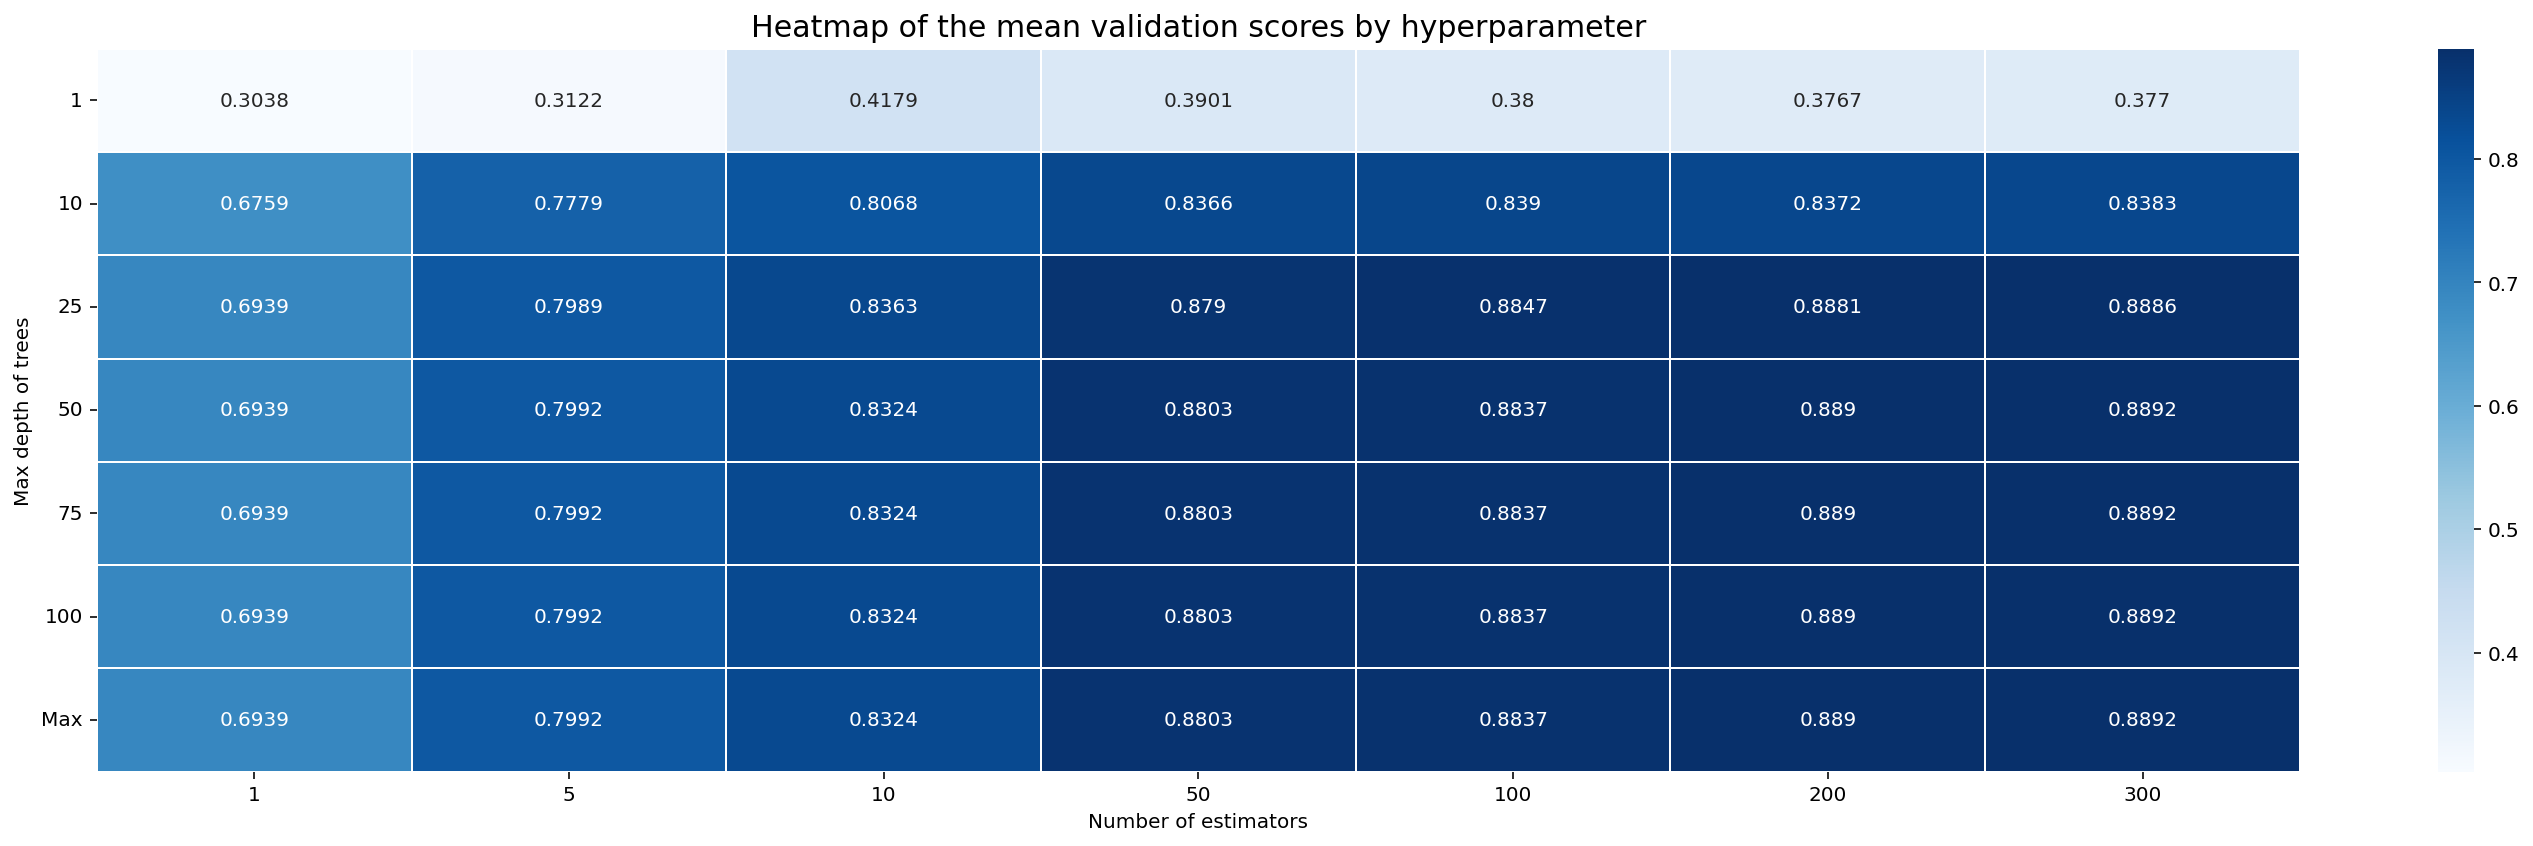

In [6]:
# Create DataFrame to host heatmap data
df_heatmap = cv_results[cols].pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
df_heatmap.index = df_heatmap.index.map(str)
df_heatmap = df_heatmap.rename(index={'nan': 'Max','1.0':'1','10.0':'10','25.0':'25','50.0':'50','75.0':'75','100.0':'100'})
df_heatmap = df_heatmap.iloc[1:].append(df_heatmap.iloc[:1])

# Plotting the results
plt.figure(figsize=(20,6))
sns.heatmap(df_heatmap, annot=True, linewidths=1, fmt=".4g", cmap="Blues")
plt.title('Heatmap of the mean validation scores by hyperparameter', size=15)
plt.xlabel('Number of estimators')
plt.ylabel('Max depth of trees')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

It can be seen that increasing the number of trees helps, as at each depth the best score always has the highest value, `300`. The heatmap also suggests that increasing the depth of trees seems to improve the overall model but we see that after a value of `50` the score doesn't improve.

Let's see also the training curves:

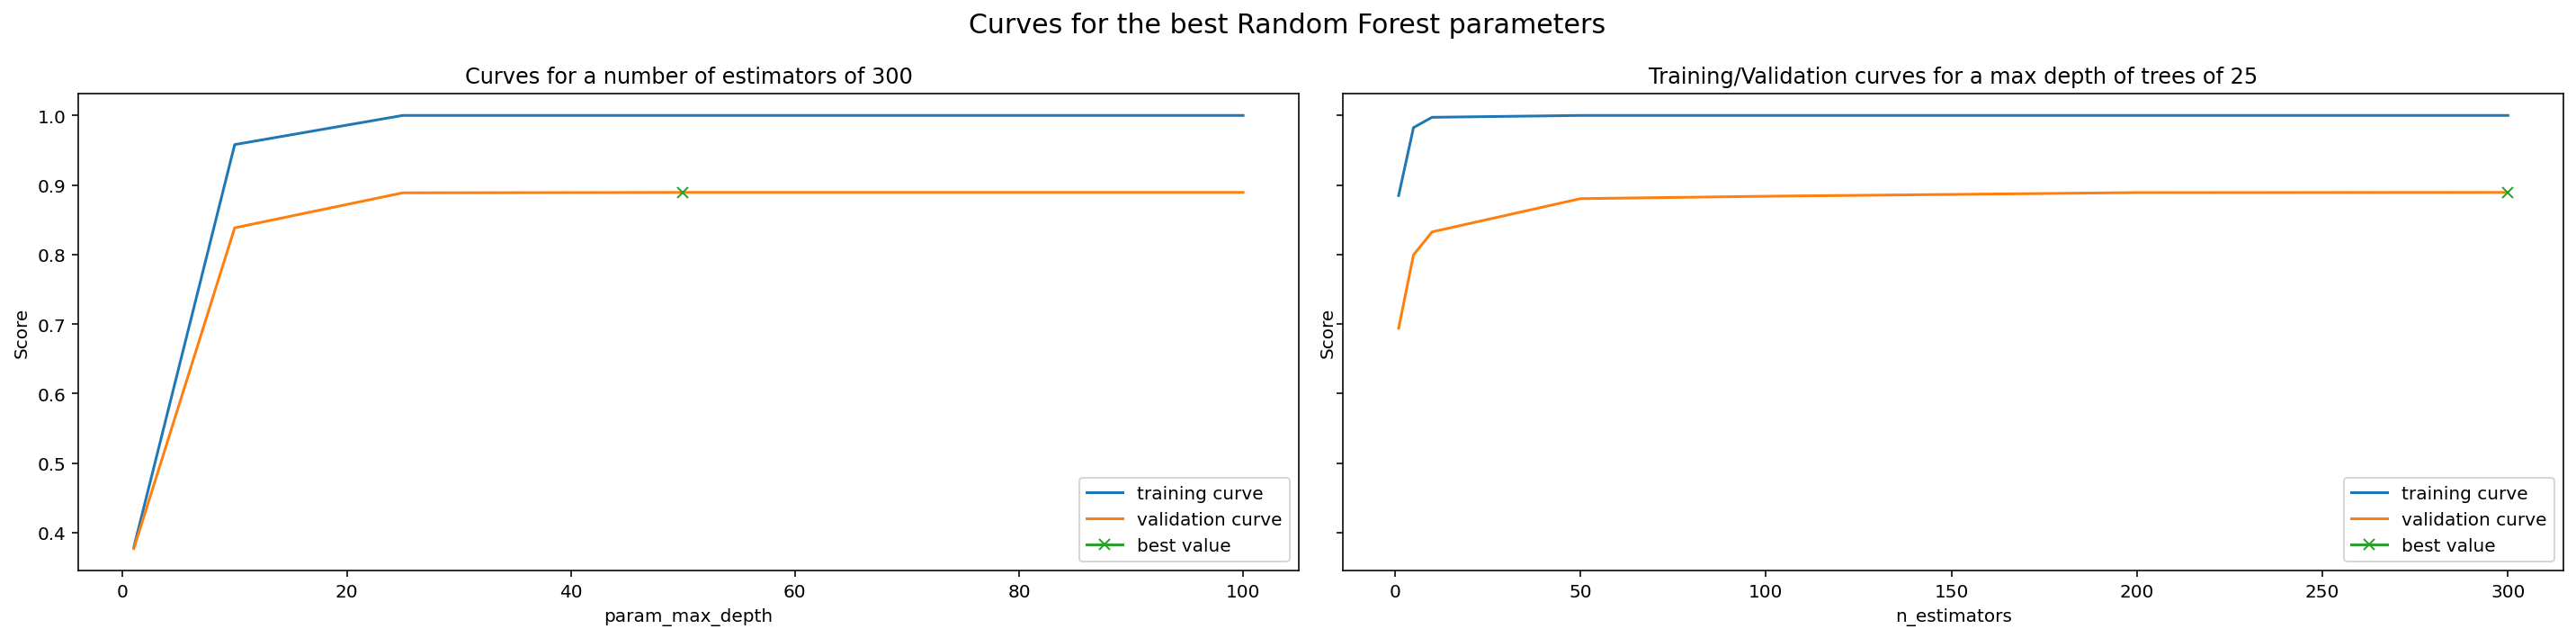

In [7]:
# Creates a figure with multiple subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

df_cv = cv_results[(cv_results["param_n_estimators"] == 300)]
axs[0].plot(df_cv["param_max_depth"], df_cv["mean_train_score"], label="training curve")
axs[0].plot(df_cv["param_max_depth"], df_cv["mean_test_score"], label="validation curve")
axs[0].plot(50, 0.8892, marker="x", label = "best value")
axs[0].set_xlabel("param_max_depth")
axs[0].set_ylabel("Score")
axs[0].set_title('Curves for a number of estimators of 300')
axs[0].legend(loc="lower right")

df_cv = cv_results[(cv_results["param_max_depth"] == 50)]
axs[1].plot(df_cv["param_n_estimators"], df_cv["mean_train_score"], label="training curve")
axs[1].plot(df_cv["param_n_estimators"], df_cv["mean_test_score"], label="validation curve")
axs[1].plot(300, 0.8892, marker="x", label = "best value")
axs[1].set_xlabel("n_estimators")
axs[1].set_ylabel("Score")
axs[1].set_title('Training/Validation curves for a max depth of trees of 25')
axs[1].legend(loc="lower right")

plt.suptitle('Curves for the best Random Forest parameters', size=15)
plt.tight_layout()
plt.show()

We can also infer from these curves that increasing both hyperparameters improves the score, but we also clearly note that there is not an improvement after a few steps. We can see that the training curves quickly reach the maximum score of 100%, a sign of overfitting. This especially for the `max_depth` parameters, as the validation score is already defined after a depth of 20~30 and even slightly decreases after the best value `50`.

Let's see the score of the test set with the otimal parameters that have been found:

In [8]:
# Create and apply the Random Forest model with the best parameters found with grid search
rf = RandomForestClassifier(n_estimators=300, max_depth=25, class_weight='balanced', random_state=0)
rf.fit(X_tr_rescaled,y_tr)

print("Test accuracy for the random forest model after the tuning: {:.3f}".format(rf.score(X_te_rescaled,y_te)))

Test accuracy for the random forest model after the tuning: 0.912


### <a id='part5c'>Most important features</a>

It can be useful to see the most important features for the random forest classifier, using the `feature_importances_` property:

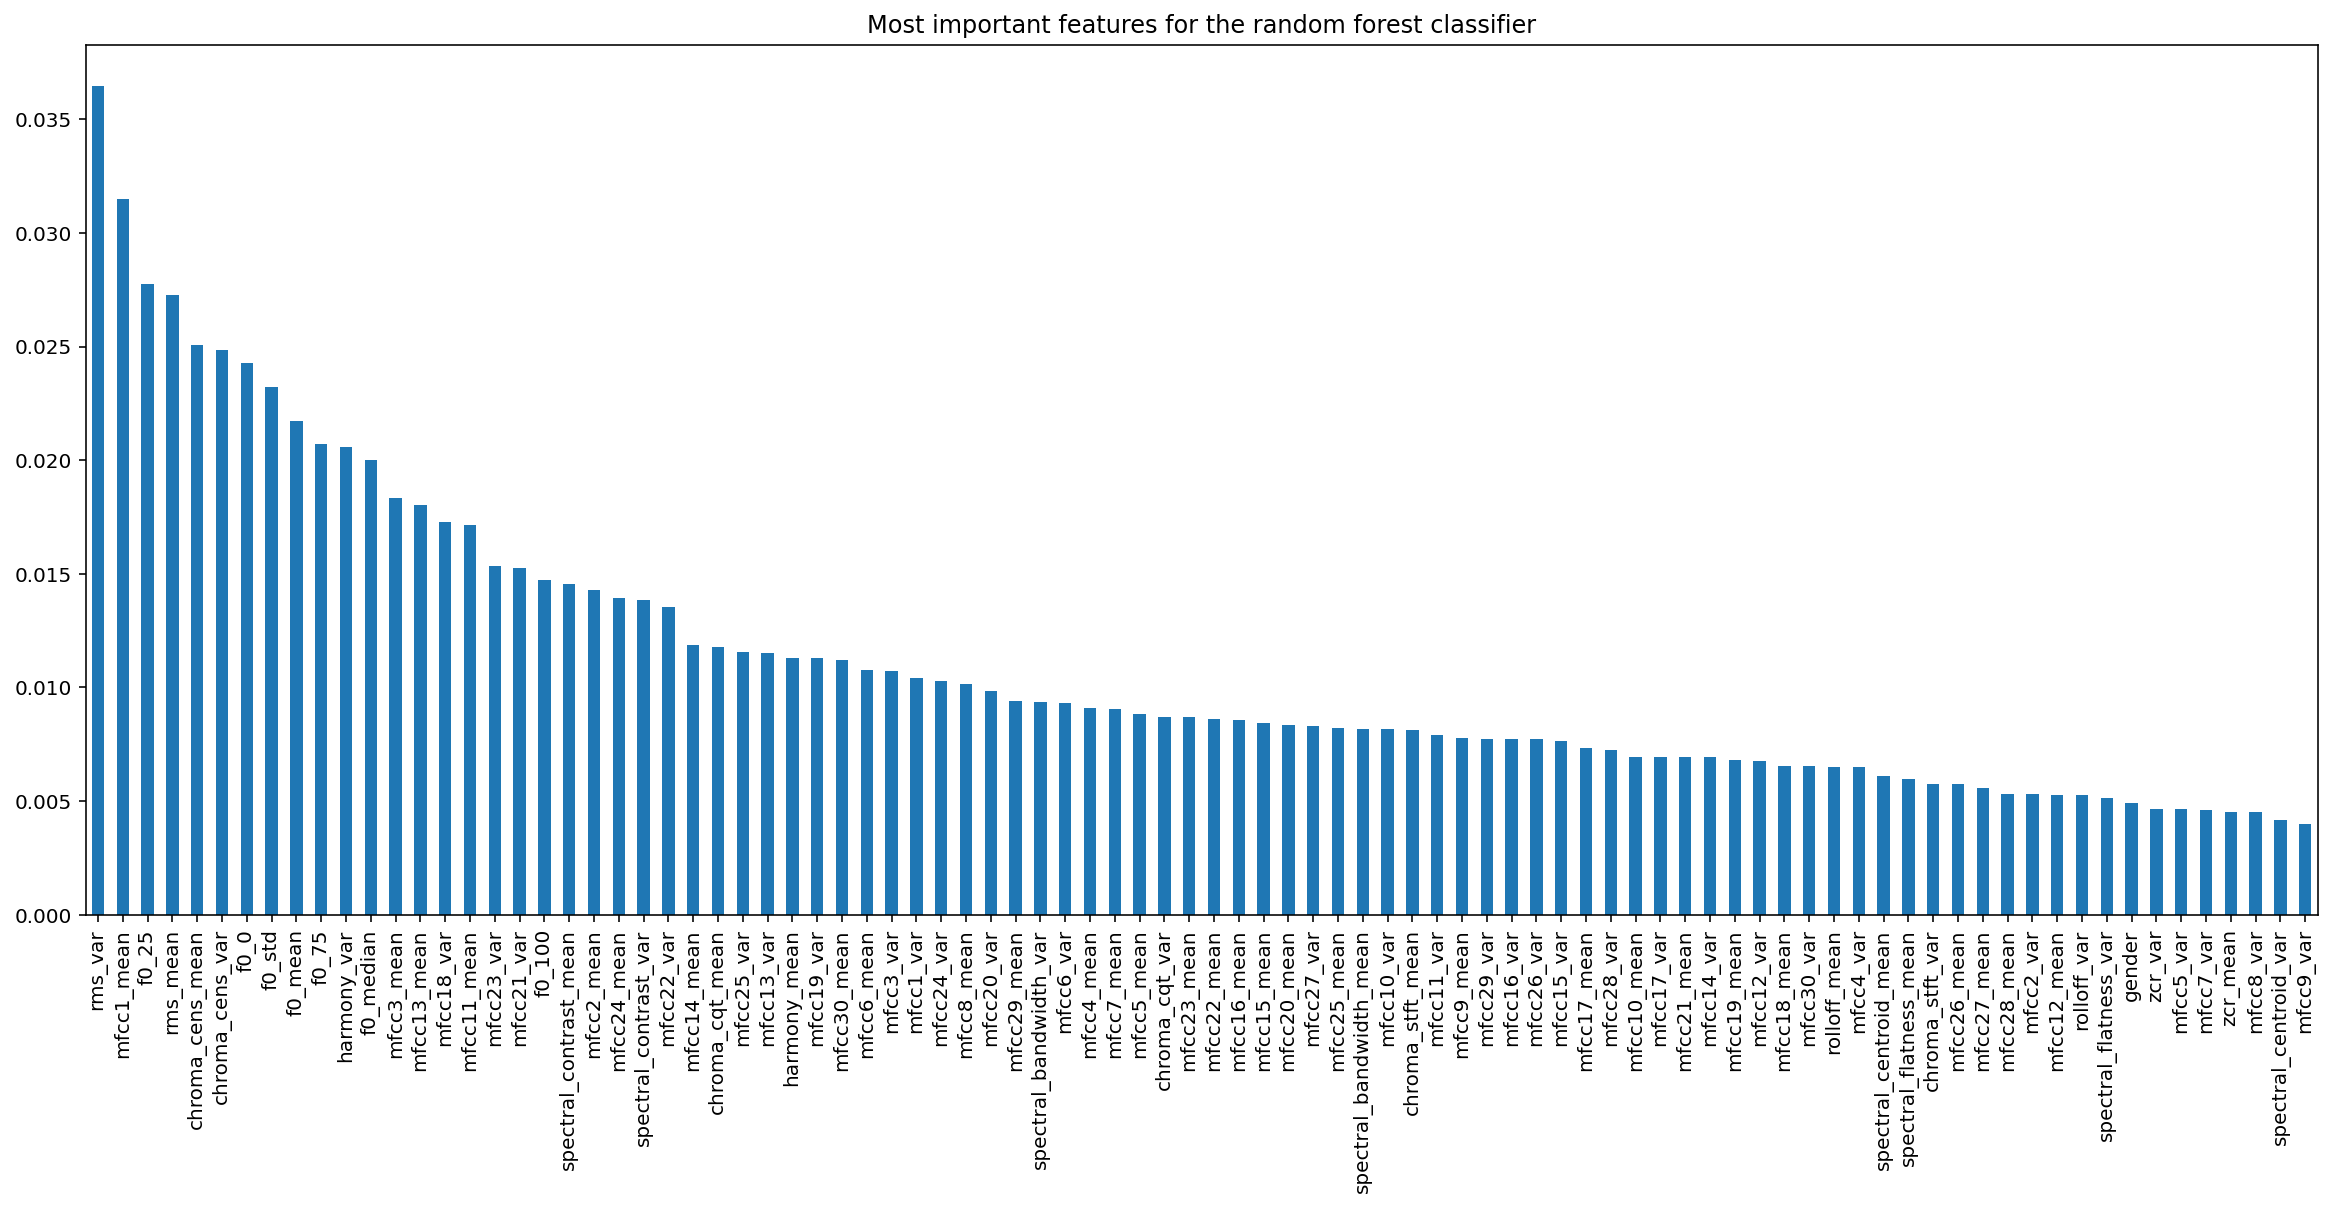

In [9]:
plt.figure(figsize=(20,8))
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
forest_importances.plot.bar(x=importances, y=X.columns)
plt.title('Most important features for the random forest classifier')
plt.show()

- Among the best features we can see the `rms` mean and variations, the fundamental frequencies, the `mfcc1_mean`, and `chroma_cens` attributes.
- Among the worst features we can see the `zero-crossing rate`, `spectral_centroid` and `spectral_flatness` values, together with some `mfccs_var`.

### <a id='5d'>Confusion Matrix</a>

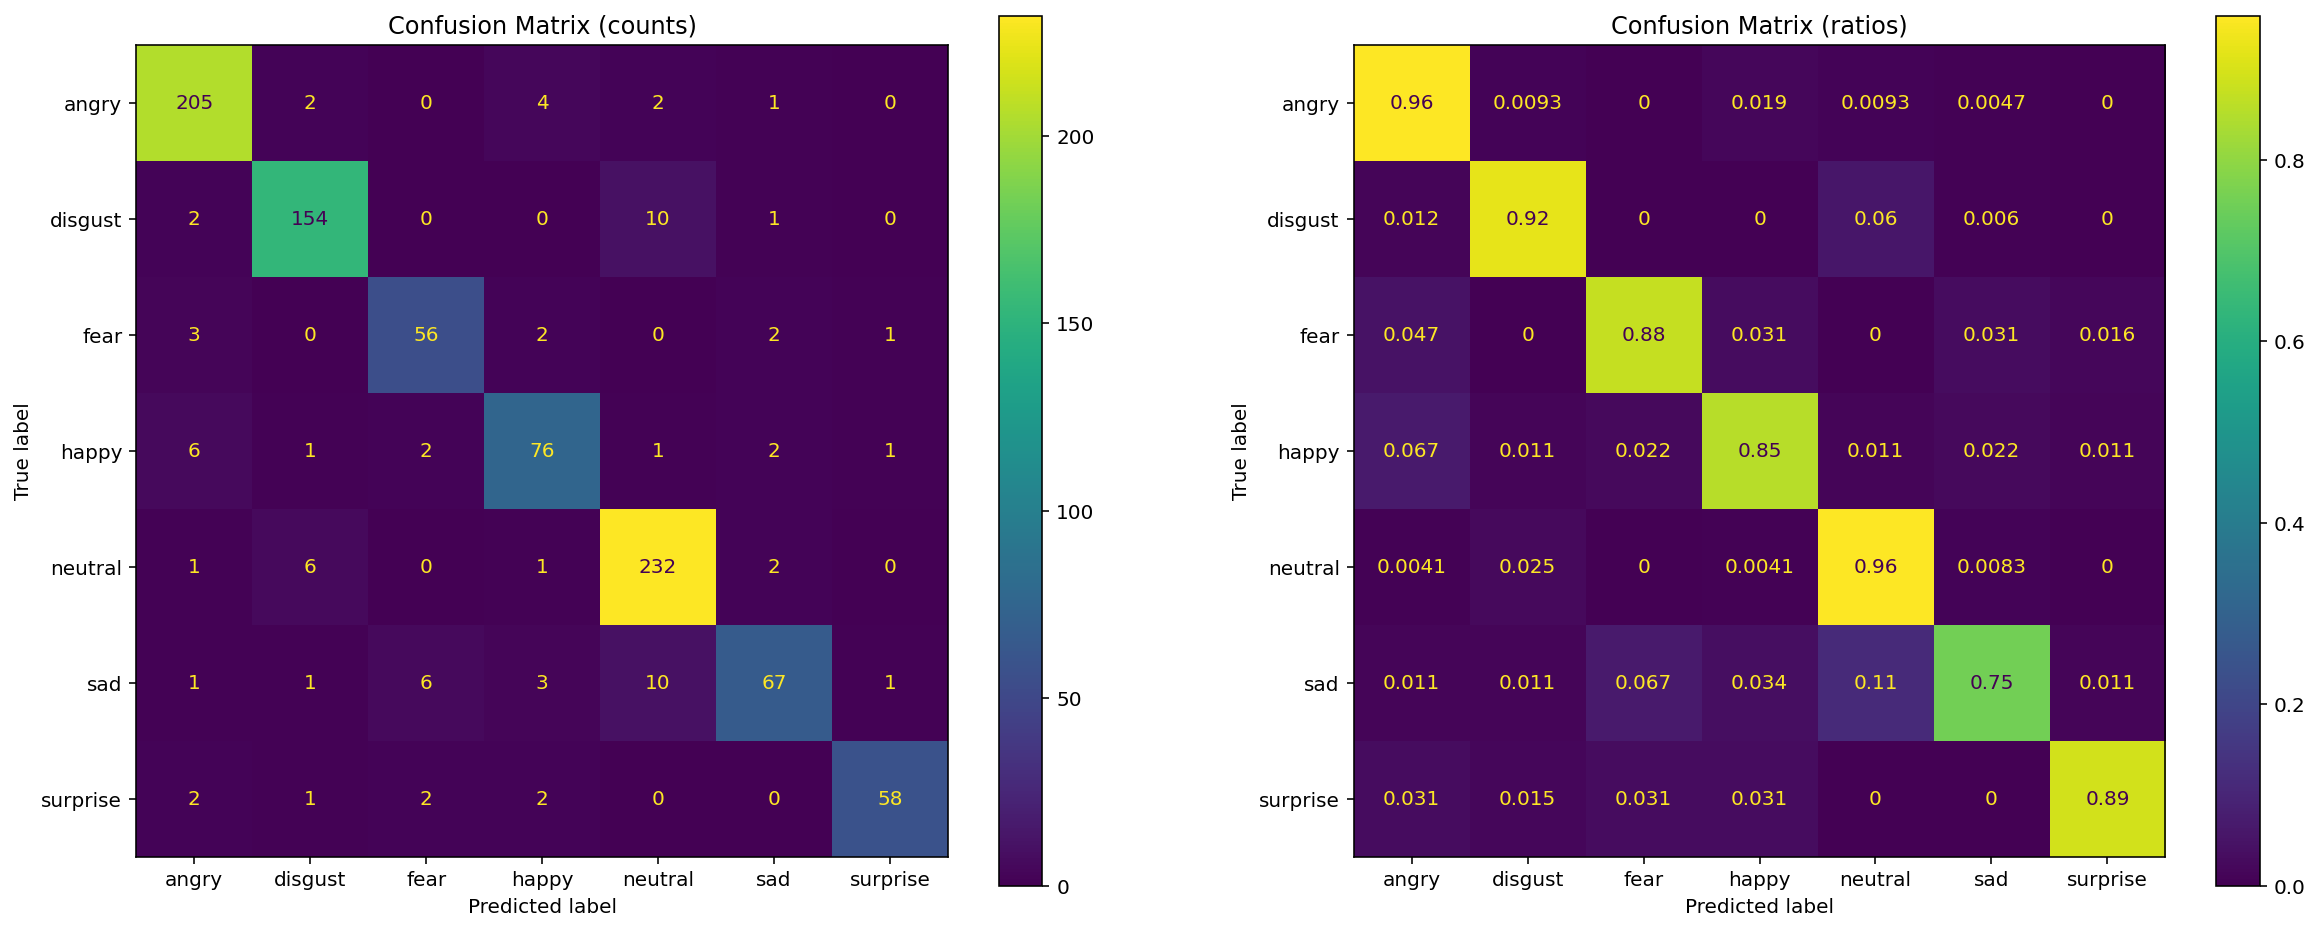

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

predicted = rf.predict(X_te_rescaled)

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)

    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, predicted)

From the confusion matrix we can see that the best emotions identified are `angry`, `neutral` and `disgust`, while `happy` and `sad` scored as the worst.

<br>[Back to top](#top5)